/Users/michaelschool/opt/anaconda3/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


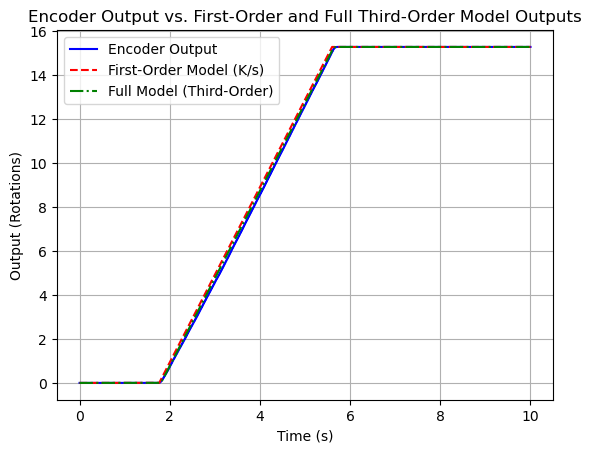

In [4]:
import scipy.io as sio
import numpy as np
from control import TransferFunction, forced_response
import matplotlib.pyplot as plt

# Load the .mat file containing encoder_output
mat_data = sio.loadmat('/Users/michaelschool/Documents/GitHub/control_plots/data/encodervals.mat')

# Check if 'encoder_output' exists in the .mat file
if 'encoder_output' in mat_data:
    encoder_output = mat_data['encoder_output'].flatten()  # Flatten to 1D array
else:
    print("Warning: 'encoder_output' is not defined. Only model outputs will be plotted.")
    encoder_output = None

# Define time vector (assuming 4422 points from 0 to 10s)
n_points = 4422
t_max = 10
time = np.linspace(0, t_max, n_points)  # Generate time vector

# Define the pulse input with 2-second rest
pulse_magnitude = 2.7
pulse_start = 1.766
pulse_end = 5.6
pulse_duration = pulse_end - pulse_start
u = np.zeros_like(time)  # Create array of zeros with same shape as time
u[(time >= pulse_start) & (time <= pulse_end)] = pulse_magnitude  # Apply pulse

# Define system parameters
K = 1.475
wn = 49
zeta = 1

# First-order model: G(s) = K/s
# In MATLAB: G_first = tf([K], [1 0])
G_first = TransferFunction([K], [1, 0])

# Second-order component: G(s) = wn^2 / (s^2 + 2*zeta*wn*s + wn^2)
# In MATLAB: G_second = tf([wn^2], [1 2*zeta*wn wn^2])
G_second = TransferFunction([wn**2], [1, 2*zeta*wn, wn**2])

# Full third-order model: G(s) = (K/s) * (second-order system)
# In MATLAB: G_full = series(G_first, G_second)
G_full = G_first * G_second  # Multiplication of transfer functions in Python

# Simulate responses
# In MATLAB: y_first = lsim(G_first, u, time)
_, y_first = forced_response(G_first, T=time, U=u)

# In MATLAB: y_full = lsim(G_full, u, time)
_, y_full = forced_response(G_full, T=time, U=u)

# Plotting
plt.figure()

# Check if encoder_output exists before plotting
if encoder_output is not None:
    plt.plot(time, encoder_output, 'b-', linewidth=1.5, label='Encoder Output')

# Plot the simulated responses
plt.plot(time, y_first, 'r--', linewidth=1.5, label='First-Order Model (K/s)')
plt.plot(time, y_full, 'g-.', linewidth=1.5, label='Full Model (Third-Order)')

# Configure plot aesthetics
plt.xlabel('Time (s)')
plt.ylabel('Output (Rotations)')
plt.title('Encoder Output vs. First-Order and Full Third-Order Model Outputs')
plt.legend()
plt.grid(True)
plt.show()

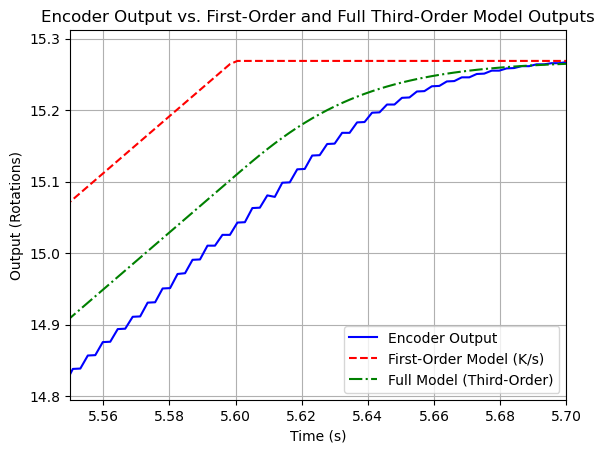

In [10]:
# Plotting
plt.figure()
if encoder_output is not None:
    plt.plot(time, encoder_output, 'b-', linewidth=1.5, label='Encoder Output')
plt.plot(time, y_first, 'r--', linewidth=1.5, label='First-Order Model (K/s)')
plt.plot(time, y_full, 'g-.', linewidth=1.5, label='Full Model (Third-Order)')
plt.xlabel('Time (s)')
plt.ylabel('Output (Rotations)')
plt.title('Encoder Output vs. First-Order and Full Third-Order Model Outputs')
plt.legend()
plt.grid(True)

# Zoom into the pulse region (1.5 to 6 seconds)
zoom_start = 5.55
zoom_end = 5.7
plt.xlim(zoom_start, zoom_end)

# Find the y-axis range in the zoomed region
mask = (time >= zoom_start) & (time <= zoom_end)
y_first_zoom = y_first[mask]
y_full_zoom = y_full[mask]
if encoder_output is not None:
    encoder_output_zoom = encoder_output[mask]
    y_min = min(y_first_zoom.min(), y_full_zoom.min(), encoder_output_zoom.min())
    y_max = max(y_first_zoom.max(), y_full_zoom.max(), encoder_output_zoom.max())
else:
    y_min = min(y_first_zoom.min(), y_full_zoom.min())
    y_max = max(y_first_zoom.max(), y_full_zoom.max())

# Add some padding to the y-axis limits
padding = 0.1 * (y_max - y_min)
plt.ylim(y_min - padding, y_max + padding)

plt.show()